# 01. Set Up

In [110]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf
import keras_ocr
import cv2
import matplotlib.pyplot as plt


from PIL import Image, ImageDraw

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


# 02. DATA LOAD

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


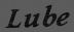

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


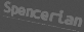

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


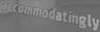

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


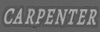

In [111]:
# data load base line
from IPython.display import display

env = lmdb.open(TRAIN_DATA_PATH,
               max_readers=32,
               readonly=True,
               lock=False,
               readahead=False,
               meminit=False)

with env.begin(write=False) as txn :
    for index in range(1,5):
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        
        try:
            img = Image.open(buf).convert('RGB')
            
        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
            
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)
        print('target_img_size:{}'.format(target_img_size))
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
        
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))
        

In [10]:
# data loader class
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비
    # lmdb에 있는 데이터 수를 미리 파악
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    

    def __getitem__(self, idx):
        
        # 1.idx에 해당하는 index_list만큼 데이터를 불러옴
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.image와 label을 불러오기
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3. 사용하기 좋은 inputs과 outputs형태로 반환
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

In [112]:
# 반복문자 처리
class LabelConverter(object):

    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [113]:
# 0~1 + A~Z 갯수
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [114]:
# 'HELLO' 샘플 확인 
label_converter = LabelConverter(TARGET_CHARACTERS)

encoded_text = label_converter.encode('HELLO')
print('Encoded text: ',encoded_text)
decoded_text = label_converter.decode(encoded_text)
print('Decoded text: ', decoded_text)

Encoded text:  [ 8  5 12  0 12 15]
Decoded text:  HEL-LO


# 03. Model Compose

In [115]:
def ctc_lambda_func(args):
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [116]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

# 04. Training

In [121]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [122]:
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'
)
history = model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop],
          verbose=2)

Epoch 1/20
565/565 - 91s - loss: 25.6909 - val_loss: 23.5283

Epoch 00001: val_loss improved from inf to 23.52828, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/20
565/565 - 83s - loss: 16.5231 - val_loss: 10.6107

Epoch 00002: val_loss improved from 23.52828 to 10.61066, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/20
565/565 - 82s - loss: 7.6874 - val_loss: 6.8333

Epoch 00003: val_loss improved from 10.61066 to 6.83332, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/20
565/565 - 83s - loss: 5.3842 - val_loss: 5.5846

Epoch 00004: val_loss improved from 6.83332 to 5.58462, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 5/20
565/565 - 83s - loss: 4.2393 - val_loss: 4.8705

Epoch 00005: val_loss improved from 5.58462 to 4.87049, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 6/20
565/565 - 82s - loss: 3.4683 - val_loss: 4.4766

Epoch 00006: val_loss improved from 4.87049 to 4.47664, saving model to

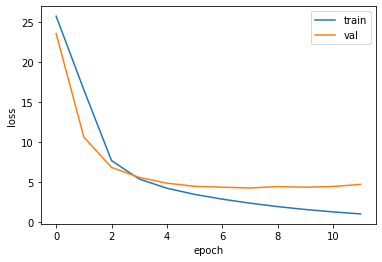

In [123]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

# 05. Test

In [129]:
# 학습된 모델의 가중치 저장 경로
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

# TEST 데이터셋, 저장된 모델불러오기
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 너무 복잡함.
# 따라서, model_input이 아닌 input_image으로 입력하고
# output에서 예측결과값 받아옴.
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING9999999999999999


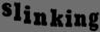

Result: 	 ALEPPO99999999999999999


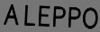

Result: 	 FWONDE999999999999999999


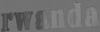

Result: 	 NATHANS99999999999999999


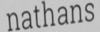

Result: 	 HALLBO99999999999999999


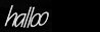

Result: 	 HURLS9999999999999999999


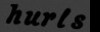

Result: 	 DOWNSIZE9999999999999999


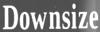

Result: 	 ROBOTIC99999999999999999


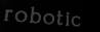

Result: 	 SLOPPY99999999999999999


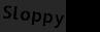

Result: 	 HERMITE99999999999999999


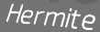

In [130]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔줌
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

# 06. End-To-End Pipeline

In [131]:
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [132]:
def detect_text(img_path):
    
    
    # 배치 크기를 위해서 dimension을 확장해주고 keras-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # (height, width, channel)
    img = np.expand_dims(img, axis=0)# (batch_size, height, width, channel)
    box_groups = detector.detect(img)

    result_img = Image.open(img_path)
    img_draw = ImageDraw.Draw(result_img)
    
    # 배치의 첫 번째 결과만 가져옵니다.
    ocr_result = box_groups[0] # 하나의 이미지에서 글자영역 갯수만큼 [[l, t], [r, t], [r, b], [l, b]]의 shape을 가짐
    
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(result_img.crop(word_box))


    return result_img, cropped_imgs

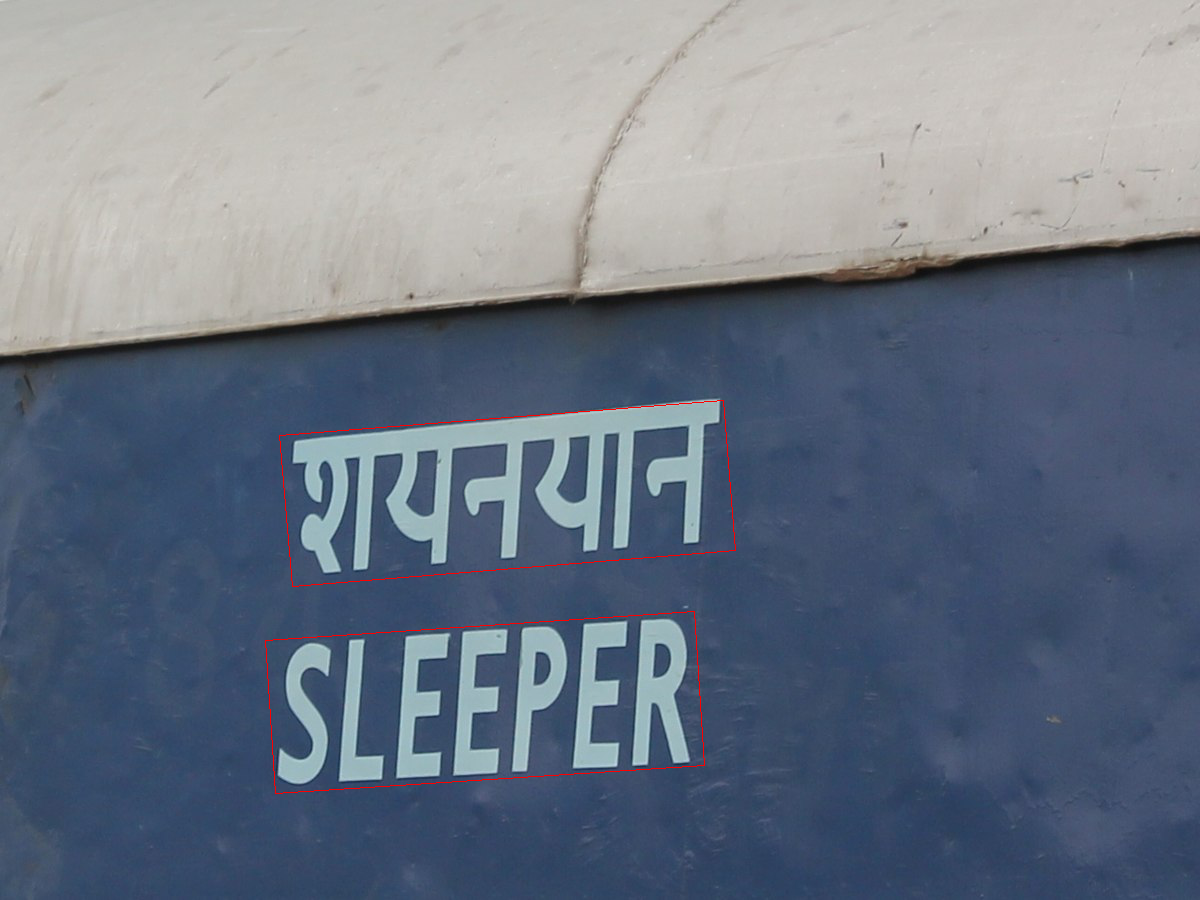

In [133]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

In [134]:
def recognize_img(pil_img, input_img_size=(100,32)):
    
    # height 32고정, widht는 width, height 비율로 조정(100이하)
    width, height = pil_img.size
    target_width = min(int(width*input_img_size[1]/height), input_img_size[0])
    target_img_size = (target_width, input_img_size[1])
    pil_img = np.array(pil_img.resize(target_img_size)).transpose(1,0,2)
    
    
    # (100,32)사이즈 랜덤이미지 만든 후 resize된 크기의 문자영역만 이미지 덮어씌우기
    input_image = np.expand_dims(np.zeros([*input_img_size, 3]),axis=0)
    input_image[0:1,:target_width,:,:] = pil_img
    
    
    output = model_pred.predict(input_image)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(input_image[0].transpose(1,0,2).astype(np.uint8)))

Result: 	 TUFUF9999999999999999999


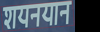

Result: 	 SLEEPER9999999999999999


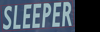

In [135]:
for _img in cropped_img:
    recognize_img(_img)

# 결과 분석

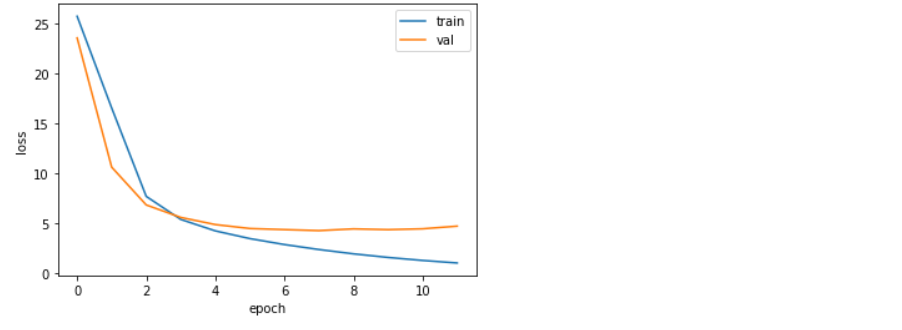

train loss와 validation loss를 확인해봤을 때 안정적으로 둘 다 비슷하게 저점을 찾을 때 까지 학습이 되는 것을 볼 수 있습니다.


또한 위의 05.Test 결과를 확인해봤을 때 recognition하여 나온 문자 역시 이미지에서 보이는 문자와 100% 동일하였습니다.

다만 Sample image로 end-to-end하여 나온 결과를 확인해보면 한글 문자는 Target 문자로 두지 않았기 때문에,\
당연히도 한글은 제대로 인식을 하지 못하고 영어로 인식이 됐습니다.

# 회고

이번에 신기한 점은 학습과정에서 img와 label 뿐만 아니라 input_length와 label_length도 학습에 이용되는 것인 것 같습니다.\
들어간 문자가 최대 몇 개인지, encoding된 label 문자 갯수가 몇 개 인지 등이 학습되면서 정확이 이미지에 문자가 몇개있는지 고려함으로써\
정확도가 많이 올라간 것이 아닌가하는 생각이 들었습니다.

그리고 한글, 일본어 등 영어 이외의 문자도 학습에 이용한다면 잘 작동할 지 앞으로 실험해보면 좋을 것 같습니다.